In [1]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# !pip install squarify

In [2]:
cd /content/drive/MyDrive/kakao

/content/drive/MyDrive/kakao


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumBarunGothic'
import seaborn as sns 
import warnings 
warnings.filterwarnings('ignore')
from tqdm import tqdm

import squarify


In [4]:
def load_dataset() : 
  data = pd.read_csv('DATASET/2019-Nov.csv', chunksize = 1000000)
  data = list(data)
  data = pd.concat(data)
  return data

data = load_dataset()
data.shape

(67501979, 9)

In [5]:
data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


In [6]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
      if col != 'price' :
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    df.drop(columns = ['category_id'], inplace = True)
    df['event_type']=df['event_type'].astype('category')
    df['category_code']=df['category_code'].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [7]:
data=reduce_mem_usage(data)

Memory usage after optimization is: 2768.13 MB
Decreased by 40.3%


In [8]:
data.head()

,event_time,event_type,product_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


In [9]:
data['event_time'] = pd.to_datetime(data['event_time'])
data['date'] = data['event_time'].dt.day
data['hour'] = data['event_time'].dt.hour
data['dayname'] = data['event_time'].dt.day_name()
data['week'] = data['event_time'].dt.week

In [10]:
dow_dict = {
    'Monday' : 0,
    'Tuesday' : 1,
    'Wednesday' : 2,
    'Thursday' : 3,
    'Friday' : 4,
    'Saturday' : 5, 
    'Sunday' : 6
}
data['dayname'] = data['dayname'].map(dow_dict)
data['dayname'] = data['dayname'].astype(np.int8)

## 상품 카테고리 분석

In [11]:
def extract_categorycode(input_text,level=0):
    output_text=input_text.split('.')[level]
    return output_text

#splitting the category text into 2 pieces as category and subcategory
data['category']=data['category_code'].apply(extract_categorycode,level=0)
data['subcategory']=data['category_code'].apply(extract_categorycode,level=1)

In [12]:
#calculating and printing informative numerical information about the dataset.
total_number_of_activity=data.shape[0]
print('Total number of activity:{:,.0f}'.format(total_number_of_activity))
print('-'*50)
total_number_of_visits=data['user_session'].nunique()
print('Total number of visits:{:,.0f}'.format(total_number_of_visits))
print('-'*50)
total_number_of_visitors=data['user_id'].nunique()
print('Total number of visitors:{:,.0f}'.format(total_number_of_visitors))
print('-'*50)
number_of_categories=data['category'].nunique()
print('The number of categories:{:,.0f}'.format(number_of_categories))
print('-'*50)
number_of_subcategories=data['subcategory'].nunique()
print('The number of subcategories:{:,.0f}'.format(number_of_subcategories))
print('-'*50)
number_of_brands=data['brand'].nunique()
print('The number of brands:{:,.0f}'.format(number_of_brands))
print('-'*50)
number_of_products=data['product_id'].nunique()
print('The number of products:{:,.0f}'.format(number_of_products))

Total number of activity:67,501,979
--------------------------------------------------
Total number of visits:13,776,050
--------------------------------------------------
Total number of visitors:3,696,117
--------------------------------------------------
The number of categories:13
--------------------------------------------------
The number of subcategories:58
--------------------------------------------------
The number of brands:4,200
--------------------------------------------------
The number of products:190,662


In [25]:
category_summary_table

NameError: ignored

In [13]:
#creating a summary table that contains an outline of categories and activities

# 카테고리별 
category_summary_table=data.groupby(by=['category']).agg(Number_of_views=('category','count'),
                                                              Number_of_users=('user_id',lambda x: x.nunique()),
                                                              Number_of_sessions=('user_session',pd.Series.nunique)).reset_index()
sales_filter=data['event_type']=='purchase'
category_sales_summary_table=data.loc[sales_filter].groupby(by=['category']).agg(Number_of_purchase=('category','count'),
                                                                                      Amount_of_purchase=('price','sum'),
                                                                                      Average_purchase_amount=('price','mean'),
                                                                                      Number_of_sessions_with_purchase=('user_session',pd.Series.nunique),
                                                                                      Number_of_shoppers=('user_id',lambda x: x.nunique())).reset_index()
category_summary_table=pd.merge(left=category_summary_table,
                               right=category_sales_summary_table,
                               left_on='category',
                               right_on='category',
                               how='left')
category_summary_table['Conversion_rate']=category_summary_table['Number_of_purchase']/category_summary_table['Number_of_sessions']

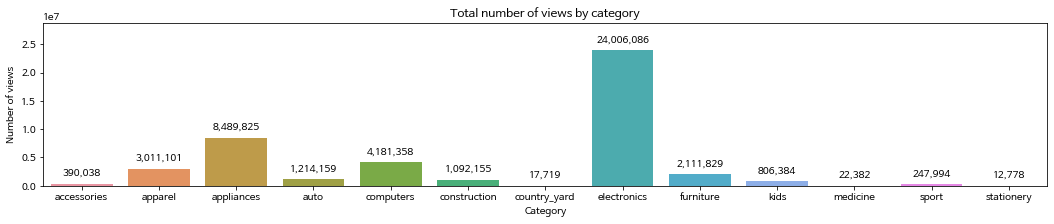

In [14]:
#creating a plot that illustrates number of visits in each category during October
plt.figure(figsize=(18,3))
plot = sns.barplot(x='category',y='Number_of_views',data=category_summary_table)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ',.0f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center',
                  va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points')

plt.title('Total number of views by category')
plt.xlabel('Category')
plt.ylabel('Number of views')
plt.ylim(0,category_summary_table['Number_of_views'].max()*1.2);

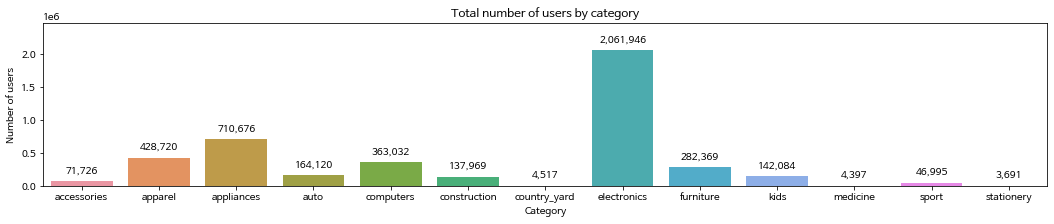

In [15]:
#creating a plot that illustrates number of visitors in each category during November
plt.figure(figsize=(18,3))
plot = sns.barplot(x='category',y='Number_of_users',data=category_summary_table)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ',.0f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center',
                  va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points')

plt.title('Total number of users by category')
plt.xlabel('Category')
plt.ylabel('Number of users')
plt.ylim(0,category_summary_table['Number_of_users'].max()*1.2);

In [16]:
#creating a subcategory summary table
category_subcategory_summary_table=data.groupby(by=['category','subcategory']).agg(Number_of_views=('category','count'),
                                                              Number_of_users=('user_id',lambda x: x.nunique()),
                                                              Number_of_sessions=('user_session',pd.Series.nunique)).reset_index()
                                
sales_filter=data['event_type']=='purchase'
category_subcategory_sales_summary_table=data.loc[sales_filter].groupby(by=['category','subcategory']).agg(Number_of_purchase=('category','count'),
                                                                                      Amount_of_purchase=('price','sum'),
                                                                                      Average_purchase_amount=('price','mean'),
                                                                                      Number_of_sessions_with_purchase=('user_session',pd.Series.nunique),
                                                                                      Number_of_shoppers=('user_id',lambda x: x.nunique())).reset_index()
category_subcategory_summary_table=pd.merge(left=category_subcategory_summary_table,
                               right=category_subcategory_sales_summary_table,
                               left_on=['category','subcategory'],
                               right_on=['category','subcategory'],
                               how='left')
category_subcategory_summary_table['Conversion_rate']=category_subcategory_summary_table['Number_of_purchase']/category_subcategory_summary_table['Number_of_sessions']
category_subcategory_summary_table['category_subcategory']=category_subcategory_summary_table['category']+'-'+category_subcategory_summary_table['subcategory']

category_subcategory_summary_table_sorted=category_subcategory_summary_table.sort_values(by='Number_of_views', ascending=False)

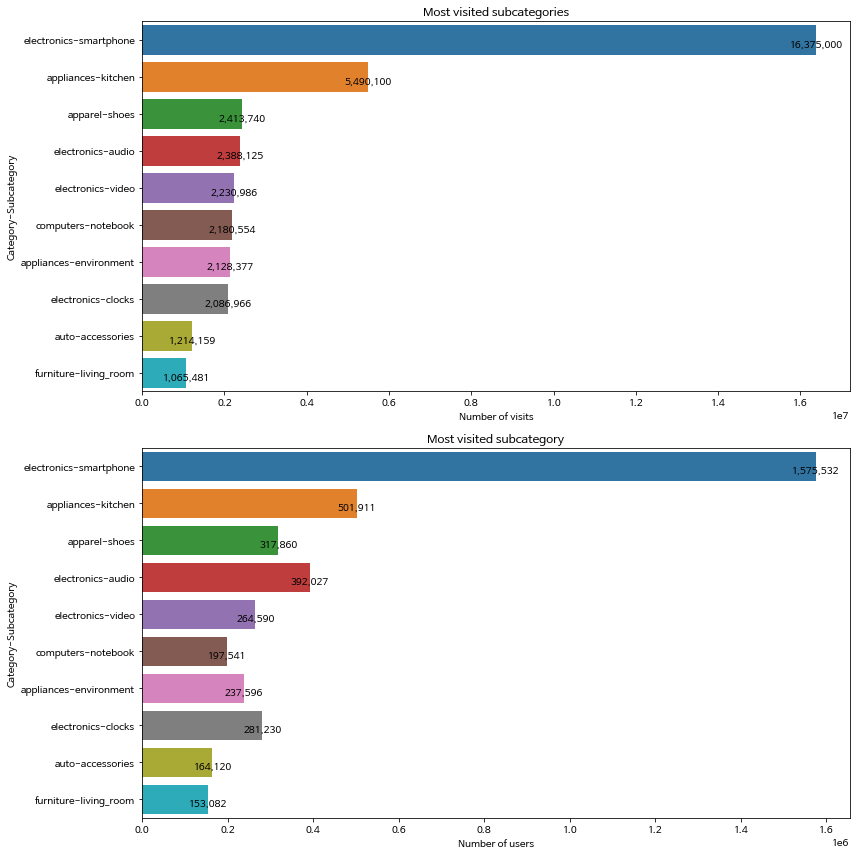

In [17]:
#creating a plot that shows most popular subcategories and number of visits and visitors during October
fig=plt.figure(figsize=(12,12))
ax1=fig.add_subplot(2,1,1)
plot=sns.barplot(x='Number_of_views',y='category_subcategory',data=category_subcategory_summary_table_sorted.head(10),ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_width(), ',.0f'),
                  (p.get_x()+p.get_width(), p.get_y() + p.get_height() ),
                  ha = 'center',
                  va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points')
plt.title('Most visited subcategories')
plt.xlabel('Number of visits')
plt.ylabel('Category-Subcategory')

ax2=fig.add_subplot(2,1,2)
plot=sns.barplot(x='Number_of_users',y='category_subcategory',data=category_subcategory_summary_table_sorted.head(10),ax=ax2)
for p in plot.patches:
    plot.annotate(format(p.get_width(), ',.0f'),
                  (p.get_x()+p.get_width(), p.get_y() + p.get_height() ),
                  ha = 'center',
                  va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points')

plt.title('Most visited subcategory')
plt.xlabel('Number of users')
plt.ylabel('Category-Subcategory')
plt.tight_layout()


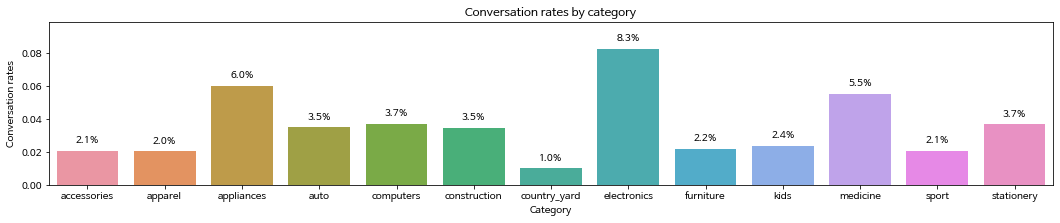

In [18]:
#creating a plot that represents conversion rates by categories
plt.figure(figsize=(18,3))
plot = sns.barplot(x='category',y='Conversion_rate',data=category_summary_table)
for p in plot.patches:
    plot.annotate("{:.1%}".format(p.get_height()),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center',
                  va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points')

plt.title('Conversation rates by category')
plt.xlabel('Category')
plt.ylabel('Conversation rates')
plt.ylim(0,category_summary_table['Conversion_rate'].max()*1.2);

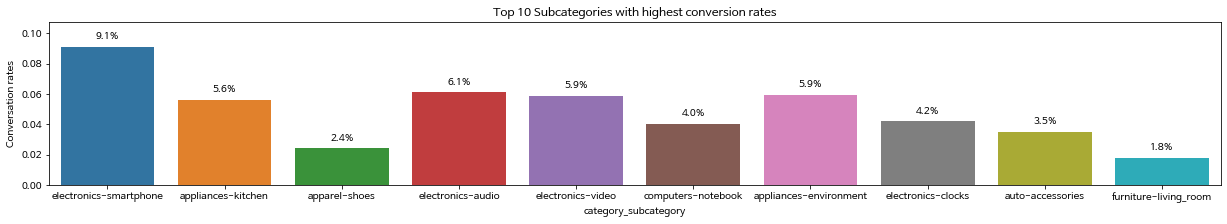

In [19]:
#creating a plot that represents subcategories with highest conversion rates
plt.figure(figsize=(21,3))
plot = sns.barplot(x='category_subcategory',y='Conversion_rate',data=category_subcategory_summary_table_sorted.head(10))
for p in plot.patches:
    plot.annotate("{:.1%}".format(p.get_height()),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center',
                  va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points')

plt.title('Top 10 Subcategories with highest conversion rates')
plt.ylabel('Conversation rates')
plt.ylim(0,category_summary_table['Conversion_rate'].max()*1.3);

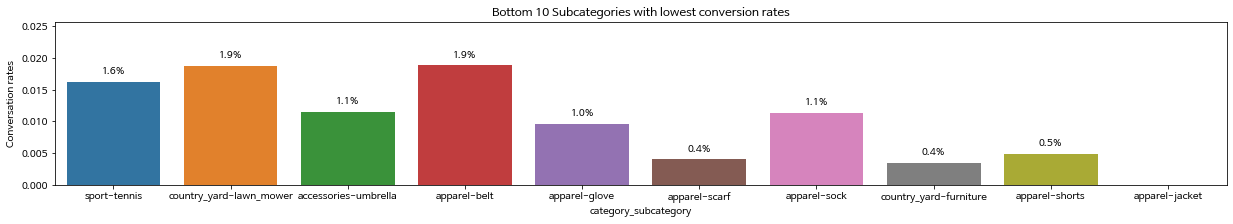

In [20]:
#creating a plot that represents subcategories with lowest conversion rates
plt.figure(figsize=(21,3))
plot = sns.barplot(x='category_subcategory',y='Conversion_rate',data=category_subcategory_summary_table_sorted.tail(10))
for p in plot.patches:
    plot.annotate("{:.1%}".format(p.get_height()),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center',
                  va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points')
plt.title('Bottom 10 Subcategories with lowest conversion rates')
plt.ylabel('Conversation rates')
plt.ylim(0,plot.get_ybound()[1]*1.3);

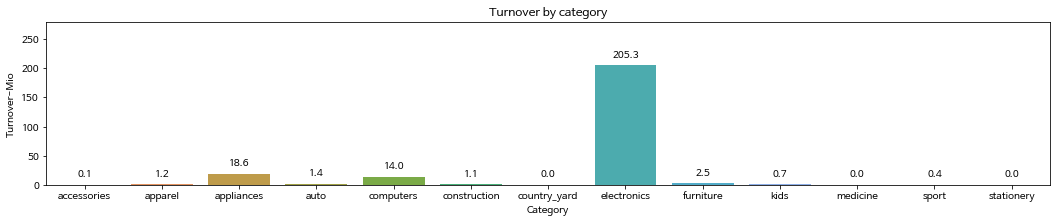

In [21]:
#creating a category turnover table
category_turnover_table=category_summary_table.groupby(by=['category']).agg(total_turnover=('Amount_of_purchase','sum')).reset_index()
category_turnover_table['total_turn_over_mio']=category_turnover_table['total_turnover']/1000000
#ploting the category turnover table 
plt.figure(figsize=(18,3))
plot = sns.barplot(x='category',y='total_turn_over_mio',data=category_turnover_table)

for p in plot.patches:
    plot.annotate(format(p.get_height(), ',.1f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center',
                  va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points')

plt.title('Turnover by category')
plt.xlabel('Category')
plt.ylabel('Turnover-Mio')
plt.ylim(0,plot.get_ybound()[1]*1.3);

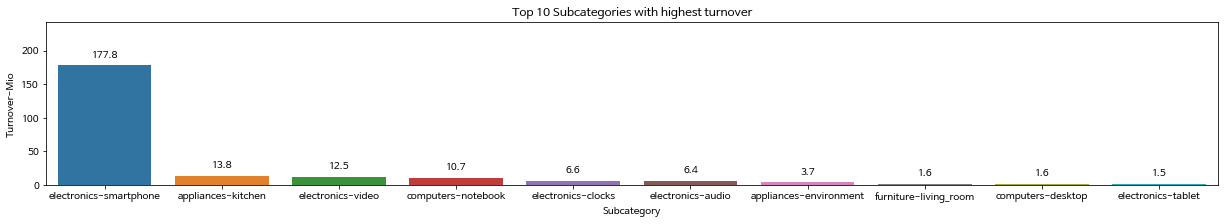

In [22]:
#creating a subcategory turnover table
subcategory_turnover_table=category_subcategory_summary_table.groupby(by=['category_subcategory']).agg(total_turnover=('Amount_of_purchase','sum')).reset_index()
subcategory_turnover_table=subcategory_turnover_table.sort_values(by=['total_turnover'],ascending=False)
subcategory_turnover_table['total_turn_over_mio']=subcategory_turnover_table['total_turnover']/1000000

#ploting top 10 subcategories with the highest turnover 
plt.figure(figsize=(21,3))
plot = sns.barplot(x='category_subcategory',y='total_turn_over_mio',data=subcategory_turnover_table.head(10))

for p in plot.patches:
    plot.annotate(format(p.get_height(), ',.1f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center',
                  va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points')

plt.title('Top 10 Subcategories with highest turnover')
plt.xlabel('Subcategory')
plt.ylabel('Turnover-Mio')
plt.ylim(0,plot.get_ybound()[1]*1.3);

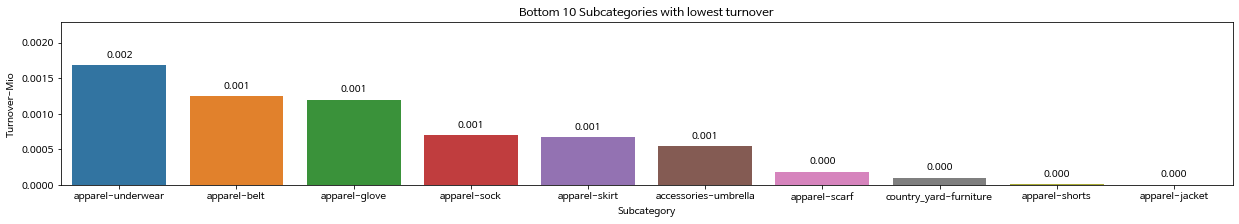

In [23]:
#ploting top 10 subcategories with the lowest turnover 
plt.figure(figsize=(21,3))
plot = sns.barplot(x='category_subcategory',y='total_turn_over_mio',data=subcategory_turnover_table.tail(10))

for p in plot.patches:
    plot.annotate(format(p.get_height(), ',.3f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center',
                  va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points')

plt.title('Bottom 10 Subcategories with lowest turnover')
plt.xlabel('Subcategory')
plt.ylabel('Turnover-Mio')
plt.ylim(0,plot.get_ybound()[1]*1.3);